# Problem 6.1: Predicting $\Omega_{\rm m}$ Using BAO Data Through $D_A$

# Background:
Recall the following relations from Lecture 3:
$$
D_C = c\int_0^z\frac{dz'}{H(z')},\qquad D_A = \frac{D_C}{1+z}
$$
or in other words,
$$
D_A = \frac{c}{1+z}\int_0^z\frac{dz'}{H(z')}
$$
where $H(z)$ is the Hubble parameter,
$$
H(z)^2 = H_0^2 \{\Omega_{\rm m}(1+z)^3+\Omega_\Lambda\},
$$
where we have assumed that we are in the matter and cosmological constant dominated universe ($\Omega_R \approx \Omega_K \approx 0$, so we have that $\Omega_{\rm m} + \Omega_\Lambda = 1$). In layman's terms, the Hubble parameter contains information on the parameter of interest, i.e. $\Omega_{\rm m}$, and this comes out in an observable, which is the angular diameter distance, $D_A$.

Our goal is to extract this information from $D_A$ using machine learning. Before we can do this, we can use `astropy` to generate theory data points for us to use in our training and testing data set.

In [87]:
#Import libraries
import numpy as np
import astropy
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

a.) Create an array of values for $\Omega_{\rm m}$ using `numpy` ranging from 0.01 to 0.9 in increments of 0.01. To generate the data, you will want to loop over the $\Omega_{\rm m}$ array and use `astropy`'s `FlatLambdaCDM` (imported in the above cell), setting $H_0=70\ {\rm km/s/Mpc}$ and $\Omega_{\rm m}$ to each value in the array you created. Then, you can use the built-in angular diameter distance function which can be called like so: `cosmo.angular_diameter_distance`. You will want to store the angular diameter distance on each loop. How can you do this?

In [88]:
#Create an array with our redshift values
z = np.array([1.50000000e-01, 3.80185957e-01, 5.10522680e-01, 6.99786511e-01,
 8.49804744e-01, 1.48071394e+00, 2.29096593e+00, 2.37085262e+00,
 1.09000000e+03])
#Generate our Omega_m's

OmM = np.arange(0.1,0.9 + 0.01,0.01)
OmM

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 ])

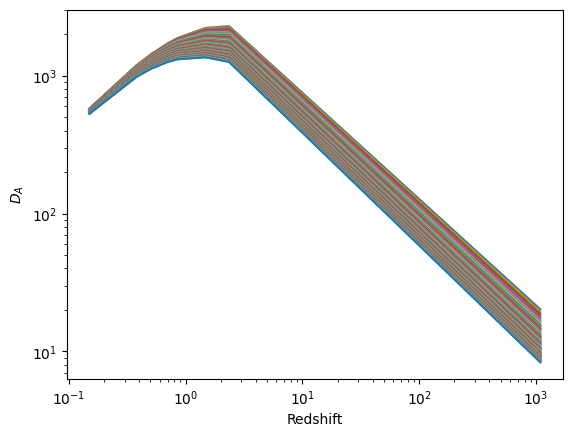

In [89]:
fig, ax = plt.subplots()
D_a = []

#Plot the D_A vs redshift for each Omega_m
for i in range(len(OmM)):
  cosmo = FlatLambdaCDM(H0=67, Om0=OmM[i])
  comoving_dist = cosmo.comoving_distance(z)
  D_a.append(comoving_dist /(1+z))

  ax.plot(z, D_a[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'$D_A$')

plt.show()

D = np.array(D_a)

b.) Now, we will prepare data from BAO, which gives us observational values for $D_A$ as a function of Redshift. We can use `numpy`'s `np.loadtxt` function to automatically load the data from a `.txt` file and store it to an array.

In [90]:
#The following code allows us to download the correct data files
!pip install gdown

In [91]:
#Load the data
import gdown

# Function to convert the shared link to the correct format
def convert_shared_link(shared_link):
    return shared_link.replace("?usp=share_link", "?usp=sharing")

shared_link = "https://drive.google.com/file/d/1VETN78tp7PIDpSzqUqBnSQoHArJi5P7I/view?usp=share_link"

# Convert the shared link to the correct format
shared_link_corrected = convert_shared_link(shared_link)

# Extract the file ID from the shared link
file_id = shared_link_corrected.split("/")[-2]

# Destination path to save the downloaded file in the Colab environment
destination_path = "/content/BAO_and_CMB_data.txt"  # You can modify the path as per your preference

# Download the file using gdown
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination_path, quiet=False)

# Load the data
data = np.loadtxt('/content/BAO_and_CMB_data.txt')
D_A_obs = data[:,1]

print(D_A_obs)

Downloading...
From: https://drive.google.com/uc?id=1VETN78tp7PIDpSzqUqBnSQoHArJi5P7I
To: /content/BAO_and_CMB_data.txt
100%|██████████| 581/581 [00:00<00:00, 983kB/s]

[ 573.54982709 1097.32455386 1308.24673246 1530.66619502 1555.79854724
 1797.73025087 1688.27398489 1634.08006572   12.54019751]


c.) We need to prepare the theory data for training and testing of the different machine learning algorithms. Using `train_test_split` function from `sklearn.model_selection`, which should split the data into a training data set and a testing data set. Then, we want to train a decision tree and random forest and make sure that they are giving us good scores with the testing data set. Finally, we will predict $\Omega_{\rm m}$ from the Pantheon Data.

In [151]:
X = D
#y = OmM.reshape(-1,1)
y = OmM

In [152]:
from sklearn.model_selection import train_test_split
#Split the data into training and testing data sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #deleting stratify

In [153]:
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# Set up decision tree with max depth of 4
my_tree = DecisionTreeRegressor(max_depth=4, random_state=1)

# Fit tree on training data
my_tree.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree.score(X_train, y_train))
print("Testing Accuracy:",my_tree.score(X_test, y_test))

Training Accuracy: 0.9972455549514199
Testing Accuracy: 0.986431974875302


In [159]:
my_tree.predict(D_A_obs.reshape(1,-1))

array([0.3975])

In [167]:
# Random forest
# Import and assign forest
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# Set up random forest with four decision trees, each with a max depth of 4
rf = RandomForestRegressor(n_estimators = 300, max_depth = 5, random_state = 1)
rf.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",rf.score(X_train, y_train))
print("Testing Accuracy:",rf.score(X_test, y_test))

Training Accuracy: 0.999740801351836
Testing Accuracy: 0.9980011278269512


In [169]:
#Predict Omega_m
rf.predict(D_A_obs.reshape(1,-1))

array([0.33662627])